In [1134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import dask.dataframe as dd

import warnings
warnings.filterwarnings('ignore')

In [1135]:
df_backup = pd.read_csv('in_time_pd.csv')

In [1136]:
df = df_backup.copy()

In [1137]:
pd.set_option('display.max_columns', None)

In [1138]:
df.head()

,#obs,avg_orig_time,avg_first_time,max_time,id,snapshot,per_end,window,status_snapshot,status_performance,MOB,Vintage,LTV_time,hpi_time,gdp_time,uer_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,MOB_2,equity_time,cep_time,id_index,partioning
0,24,-7.0,25.0,48,1,25,37,7,0.0,0.0,32.0,0,24.498336,226.29,2.899137,4.7,715,69.4,9.2,87.03,1024,0.755017,-0.036380,1-25,in-time sample
1,24,-7.0,25.0,48,1,29,41,8,0.0,0.0,36.0,0,24.925476,217.37,1.692969,4.5,715,69.4,9.2,87.03,1296,0.750745,-0.037937,1-29,in-time sample
2,24,-7.0,25.0,48,1,33,45,9,0.0,0.0,40.0,0,25.584425,180.52,0.836859,5.0,715,69.4,9.2,87.03,1600,0.744156,0.010269,1-33,in-time sample
3,24,-7.0,25.0,48,1,37,49,10,0.0,1.0,44.0,0,28.347862,153.35,-4.146711,9.0,715,69.4,9.2,87.03,1600,0.716521,0.018660,1-37,in-time sample
4,24,-7.0,25.0,48,1,41,53,11,0.0,1.0,48.0,0,26.687875,161.06,2.682497,9.9,715,69.4,9.2,87.03,1600,0.733121,0.009989,1-41,in-time sample


In [1139]:
reqd_col_for_model = ['status_performance','LTV_time','Interest_Rate_orig_time','hpi_time','gdp_time','uer_time','FICO_orig_time','LTV_orig_time','hpi_orig_time','Vintage','MOB','equity_time','cep_time']

In [1140]:
df = df.loc[:, reqd_col_for_model]

In [1141]:
df.shape

(26873, 13)

In [1142]:
y_proportion = df[df['status_performance'] == 0]['status_performance'].count()/df['status_performance'].count(), df[df['status_performance'] == 1]['status_performance'].count()/df['status_performance'].count()
y_proportion

(0.7605403192795743, 0.2394596807204257)

<Axes: xlabel='status_performance'>

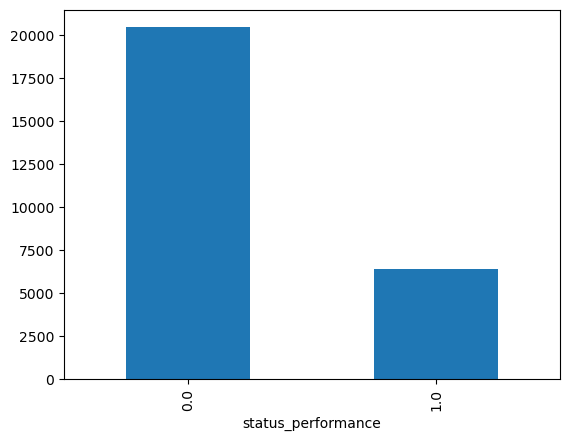

In [1143]:
df.groupby('status_performance').size().plot(kind='bar')

### Basic EDA is completed before model designing.

### Visual Exploratory Data Analysis

array([[<Axes: title={'center': 'status_performance'}>,
        <Axes: title={'center': 'LTV_time'}>,
        <Axes: title={'center': 'Interest_Rate_orig_time'}>,
        <Axes: title={'center': 'hpi_time'}>],
       [<Axes: title={'center': 'gdp_time'}>,
        <Axes: title={'center': 'uer_time'}>,
        <Axes: title={'center': 'FICO_orig_time'}>,
        <Axes: title={'center': 'LTV_orig_time'}>],
       [<Axes: title={'center': 'hpi_orig_time'}>,
        <Axes: title={'center': 'Vintage'}>,
        <Axes: title={'center': 'MOB'}>,
        <Axes: title={'center': 'equity_time'}>],
       [<Axes: title={'center': 'cep_time'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

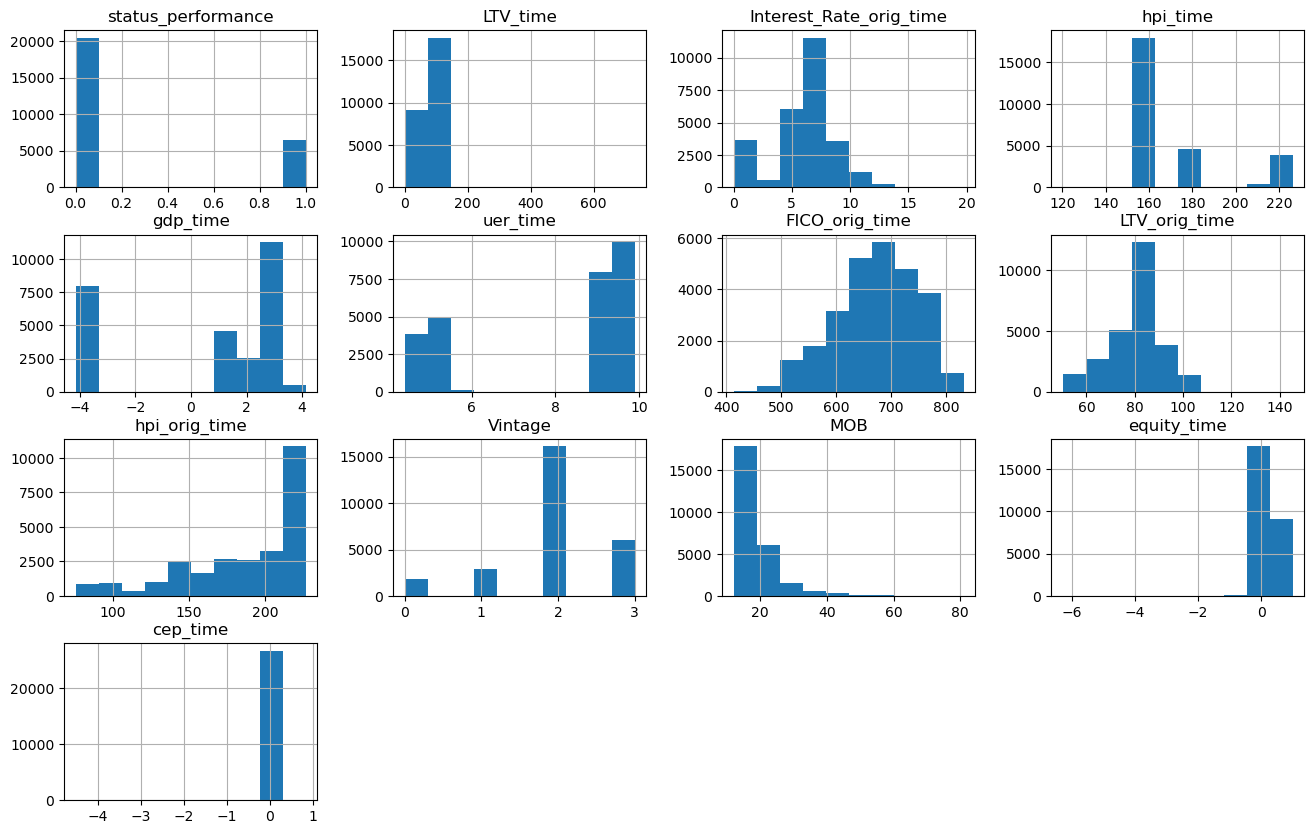

In [1144]:
df.hist(['status_performance','LTV_time','Interest_Rate_orig_time','hpi_time','gdp_time','uer_time','FICO_orig_time',
         'LTV_orig_time','hpi_orig_time','Vintage','MOB','equity_time','cep_time'],
        figsize=(16,10))

### Missing Values Treatment

In [1145]:
df.isna().sum()

status_performance         0
LTV_time                   0
Interest_Rate_orig_time    0
hpi_time                   0
gdp_time                   0
uer_time                   0
FICO_orig_time             0
LTV_orig_time              0
hpi_orig_time              0
Vintage                    0
MOB                        0
equity_time                0
cep_time                   1
dtype: int64

In [1146]:
#Since there is only one missing value, we can drop it
df.dropna(inplace = True)

In [1147]:
df.isna().sum()

status_performance         0
LTV_time                   0
Interest_Rate_orig_time    0
hpi_time                   0
gdp_time                   0
uer_time                   0
FICO_orig_time             0
LTV_orig_time              0
hpi_orig_time              0
Vintage                    0
MOB                        0
equity_time                0
cep_time                   0
dtype: int64

### Basic Data Exploration

In [1148]:
df.describe(include = 'all')

,status_performance,LTV_time,Interest_Rate_orig_time,hpi_time,gdp_time,uer_time,FICO_orig_time,LTV_orig_time,hpi_orig_time,Vintage,MOB,equity_time,cep_time
count,26872.000000,26872.000000,26872.000000,26872.000000,26872.000000,26872.000000,26872.000000,26872.000000,26872.000000,26872.000000,26872.000000,26872.000000,26872.000000
mean,0.239469,84.733794,5.995438,171.309498,0.270042,7.949516,672.368264,78.982383,186.923687,1.983849,18.320631,0.152662,-0.038532
std,0.426767,29.584854,2.793815,22.875128,2.953579,2.232683,73.712598,10.556226,40.551111,0.774654,7.580380,0.295849,0.054299
min,0.000000,0.000000,0.000000,120.030000,-4.146711,4.400000,413.000000,50.100000,75.710000,0.000000,12.000000,-6.306256,-4.525025
25%,0.000000,61.722019,5.375000,153.350000,-4.146711,5.000000,625.750000,74.600000,161.270000,2.000000,14.000000,-0.088184,-0.055128
50%,0.000000,89.050139,6.375000,161.060000,1.692969,9.000000,678.000000,80.000000,199.210000,2.000000,16.000000,0.109499,-0.035439
75%,0.000000,108.818415,7.500000,180.520000,2.682497,9.900000,729.000000,83.500000,222.390000,2.000000,20.000000,0.382780,-0.020571
max,1.000000,730.625601,19.750000,226.290000,4.126684,9.900000,832.000000,145.400000,226.290000,3.000000,81.000000,1.000000,0.837914


In [1149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26872 entries, 0 to 26872
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   status_performance       26872 non-null  float64
 1   LTV_time                 26872 non-null  float64
 2   Interest_Rate_orig_time  26872 non-null  float64
 3   hpi_time                 26872 non-null  float64
 4   gdp_time                 26872 non-null  float64
 5   uer_time                 26872 non-null  float64
 6   FICO_orig_time           26872 non-null  int64  
 7   LTV_orig_time            26872 non-null  float64
 8   hpi_orig_time            26872 non-null  float64
 9   Vintage                  26872 non-null  int64  
 10  MOB                      26872 non-null  float64
 11  equity_time              26872 non-null  float64
 12  cep_time                 26872 non-null  float64
dtypes: float64(11), int64(2)
memory usage: 2.9 MB


In [1150]:
df.nunique()

status_performance             2
LTV_time                   25592
Interest_Rate_orig_time      818
hpi_time                      10
gdp_time                      10
uer_time                      10
FICO_orig_time               375
LTV_orig_time                514
hpi_orig_time                 64
Vintage                        4
MOB                          113
equity_time                25592
cep_time                   25829
dtype: int64

In [1151]:
df['Vintage'].unique()

array([0, 2, 3, 1], dtype=int64)

In [1152]:
df['Vintage1'] = np.where(df['Vintage'] == 0,1,0)
df['Vintage2'] = np.where(df['Vintage'] == 1,1,0)
df['Vintage3'] = np.where(df['Vintage'] == 2,1,0)

In [1153]:
df.drop(columns = 'Vintage', inplace=True)

In [1154]:
df['MOB'] = df['MOB'].round(0)

## Statistical Feature Selection (Categorical Vs Continuous) using ANOVA test

Analysis of variance(ANOVA) is performed to check if there is any relationship between the given continuous and categorical variable

Assumption(H0): There is NO relation between the given variables (i.e. The average(mean) values of the numeric Predictor variable is same for all the groups in the categorical Target variable)

In [1155]:
def FunctionAnova(inpData,TargetVariable,ContinousPredictorList):
    from scipy.stats import f_oneway
    
    SelectedPredictors = []
    
    print('\n#### ANOVA Results #####\n')
    
    for predictor in ContinousPredictorList:
        CategoryGroupLists = inpData.groupby(TargetVariable)[predictor].apply(list)
        AnovaResults = f_oneway(*CategoryGroupLists)
        
        if (AnovaResults[1]<0.05):
            print(predictor,'is correlated with',TargetVariable,'|P-value',AnovaResults[1])
            SelectedPredictors.append(predictor)
            
        else:
            print(predictor,'is NOT correlated with',TargetVariable,'P-Value',AnovaResults[1])
            
    return(SelectedPredictors)

In [1156]:
FunctionAnova(inpData=df,TargetVariable='status_performance', 
              ContinousPredictorList=df.drop(columns='status_performance'))


#### ANOVA Results #####

LTV_time is correlated with status_performance |P-value 2.17334644265281e-236
Interest_Rate_orig_time is correlated with status_performance |P-value 9.014649629365732e-17
hpi_time is correlated with status_performance |P-value 2.82944090271868e-44
gdp_time is correlated with status_performance |P-value 5.5468927689880066e-06
uer_time is correlated with status_performance |P-value 3.012519553436588e-39
FICO_orig_time is correlated with status_performance |P-value 7.732308608853914e-96
LTV_orig_time is correlated with status_performance |P-value 4.4514048196849125e-25
hpi_orig_time is correlated with status_performance |P-value 5.9562168642834774e-154
MOB is correlated with status_performance |P-value 1.111541213926315e-92
equity_time is correlated with status_performance |P-value 2.17334644265281e-236
cep_time is correlated with status_performance |P-value 5.351289178032207e-73
Vintage1 is correlated with status_performance |P-value 7.99660087445202e-23
Vintag

['LTV_time',
 'Interest_Rate_orig_time',
 'hpi_time',
 'gdp_time',
 'uer_time',
 'FICO_orig_time',
 'LTV_orig_time',
 'hpi_orig_time',
 'MOB',
 'equity_time',
 'cep_time',
 'Vintage1',
 'Vintage2',
 'Vintage3']

### Paired t-test

In [1157]:
df.columns

Index(['status_performance', 'LTV_time', 'Interest_Rate_orig_time', 'hpi_time',
       'gdp_time', 'uer_time', 'FICO_orig_time', 'LTV_orig_time',
       'hpi_orig_time', 'MOB', 'equity_time', 'cep_time', 'Vintage1',
       'Vintage2', 'Vintage3'],
      dtype='object')

In [1158]:
df.drop(columns = ['status_performance']).columns

Index(['LTV_time', 'Interest_Rate_orig_time', 'hpi_time', 'gdp_time',
       'uer_time', 'FICO_orig_time', 'LTV_orig_time', 'hpi_orig_time', 'MOB',
       'equity_time', 'cep_time', 'Vintage1', 'Vintage2', 'Vintage3'],
      dtype='object')

In [1159]:
import scipy.stats as stats 

In [1160]:
from scipy.stats import ttest_rel

In [1161]:
reqd_col = df.drop(columns=['status_performance']).columns

# Initialize a dictionary to store t-test results
t_test_results = {}

# Loop through each column and perform the paired t-test
for col in reqd_col:
    t_stat, p_value = ttest_rel(df['status_performance'], df[col])
    significance = 'significant' if p_value < 0.05 else 'insignificant'
    t_test_results[col] = {'t-statistic': t_stat, 'p-value': p_value, 'significance': significance}

# Convert results to a DataFrame for better visualization
t_test_results_df = pd.DataFrame(t_test_results).T

# Display the t-test results
print(t_test_results_df)

                         t-statistic   p-value   significance
LTV_time                 -469.470691       0.0    significant
Interest_Rate_orig_time   -331.35966       0.0    significant
hpi_time                -1223.763494       0.0    significant
gdp_time                   -1.672848  0.094369  insignificant
uer_time                 -564.387247       0.0    significant
FICO_orig_time          -1493.607161       0.0    significant
LTV_orig_time           -1224.915341       0.0    significant
hpi_orig_time            -755.899706       0.0    significant
MOB                      -387.703903       0.0    significant
equity_time                25.165855       0.0    significant
cep_time                    104.5013       0.0    significant
Vintage1                   55.744483       0.0    significant
Vintage2                   39.912762       0.0    significant
Vintage3                  -89.202406       0.0    significant


In [1162]:
### Dropping gdp as this is insignifiacnt
df.drop('gdp_time', axis = 1, inplace = True)

In [1163]:
df.drop('status_performance', axis = 1).columns

Index(['LTV_time', 'Interest_Rate_orig_time', 'hpi_time', 'uer_time',
       'FICO_orig_time', 'LTV_orig_time', 'hpi_orig_time', 'MOB',
       'equity_time', 'cep_time', 'Vintage1', 'Vintage2', 'Vintage3'],
      dtype='object')

In [1164]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
vif_data = pd.DataFrame()
df_predictors = df.drop('status_performance', axis = 1)
vif_data['feature'] = df_predictors.columns

# Calculate VIF and store it in the DataFrame
vif_data['VIF'] = [variance_inflation_factor(df_predictors.values, i) for i in range(df_predictors.shape[1])]

print(vif_data)

                    feature          VIF
0                  LTV_time  1225.270207
1   Interest_Rate_orig_time     1.146128
2                  hpi_time     5.092930
3                  uer_time     4.968860
4            FICO_orig_time     1.153216
5             LTV_orig_time     4.313735
6             hpi_orig_time    20.980063
7                       MOB     5.389560
8               equity_time   109.676919
9                  cep_time     2.162077
10                 Vintage1     5.209283
11                 Vintage2     3.516712
12                 Vintage3     2.298813


In [1165]:
cols_to_drop = ['LTV_time', 'hpi_orig_time', 'equity_time']

df.drop(columns = cols_to_drop, inplace=True)

In [1166]:
from sklearn.model_selection import train_test_split

In [1167]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('status_performance', axis = 1),df['status_performance'], test_size = 0.2, random_state = 42
)

In [1168]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21497, 10), (5375, 10), (21497,), (5375,))

In [1225]:
# df_inputs_preprocess = X_train
# df_target_preprocess = y_train
df_inputs_preprocess = X_test
df_target_preprocess = y_test

In [1226]:
df_inputs_preprocess.columns

Index(['Interest_Rate_orig_time', 'hpi_time', 'uer_time', 'FICO_orig_time',
       'LTV_orig_time', 'MOB', 'cep_time', 'Vintage1', 'Vintage2', 'Vintage3'],
      dtype='object')

### Function to calculate WoE and IV

In [1227]:
def woe_discrete(df, discrete_variable_name, good_bad_variable_df):
    df = pd.concat([df[discrete_variable_name], good_bad_variable_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
               df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()],
               axis = 1)
    df = df.iloc[: , [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_bad']
    df['prop_good'] = 1 - df['prop_bad']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = df['prop_bad'] * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_bad']/df['prop_n_good'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_bad'] - df['prop_n_good']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [1228]:
def woe_cont(df, cont_variable_name, good_bad_variable_df):
    df = pd.concat([df[cont_variable_name], good_bad_variable_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
               df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()],
               axis = 1)
    df = df.iloc[: , [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_bad']
    df['prop_good'] = 1 - df['prop_bad']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = df['prop_bad'] * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_bad']/df['prop_n_good'])
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_bad'] - df['prop_n_good']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [1229]:
#For visualization

def plot_by_woe(df_WoE, rotation_of_x_label = 0, fig_size = (18,6)):
    x = np.array(df_WoE.iloc[ : ,0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize = fig_size)
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_label)

In [1230]:
def iv_status(x):
    if x < 0.02:
        return 'useless'
    elif 0.02 <= x < 0.10:
        return 'weak predictor'
    elif 0.10 <= x < 0.30:
        return 'medium predictor'
    elif 0.30 <= x < 0.50:
        return 'strong predictor'
    elif x >= 0.50:
        return 'suspicious'        

#### WoE, IV for Interest_Rate_orig_time

In [1231]:
df_inputs_preprocess['Interest_Rate_orig_time_factor'] = pd.cut(df_inputs_preprocess['Interest_Rate_orig_time'], bins=20)
df_Interest_Rate_orig_time_factor = woe_cont(df_inputs_preprocess,'Interest_Rate_orig_time_factor', df_target_preprocess)
df_Interest_Rate_orig_time_factor

,Interest_Rate_orig_time_factor,n_obs,prop_bad,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_WoE,IV
0,"(-0.018, 0.9]",568,0.322183,0.677817,0.105674,385.0,183.0,0.094109,0.142523,0.415052,NaN,inf
1,"(0.9, 1.8]",130,0.407692,0.592308,0.024186,77.0,53.0,0.018822,0.041277,0.785296,0.370244,inf
2,"(1.8, 2.7]",51,0.196078,0.803922,0.009488,41.0,10.0,0.010022,0.007788,-0.252178,1.037473,inf
3,"(2.7, 3.6]",75,0.120000,0.880000,0.013953,66.0,9.0,0.016133,0.007009,-0.833621,0.581443,inf
4,"(3.6, 4.5]",101,0.089109,0.910891,0.018791,92.0,9.0,0.022488,0.007009,-1.165755,0.332134,inf
5,"(4.5, 5.4]",462,0.155844,0.844156,0.085953,390.0,72.0,0.095331,0.056075,-0.530671,0.635083,inf
6,"(5.4, 6.3]",1198,0.176962,0.823038,0.222884,986.0,212.0,0.241017,0.165109,-0.378261,0.152411,inf
7,"(6.3, 7.2]",1184,0.244932,0.755068,0.220279,894.0,290.0,0.218528,0.225857,0.032984,0.411245,inf
8,"(7.2, 8.1]",730,0.294521,0.705479,0.135814,515.0,215.0,0.125886,0.167445,0.285280,0.252296,inf
9,"(8.1, 9.0]",430,0.258140,0.741860,0.080000,319.0,111.0,0.077976,0.086449,0.103148,0.182132,inf


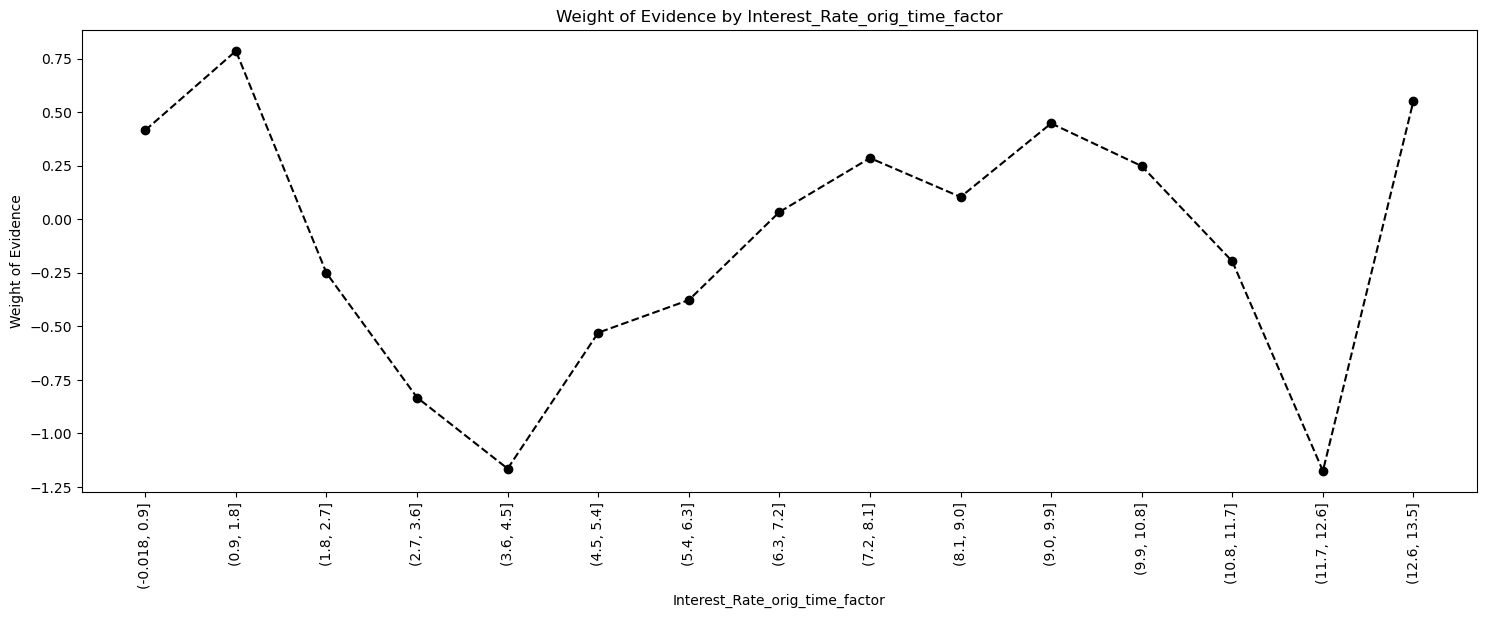

In [1232]:
plot_by_woe(df_Interest_Rate_orig_time_factor, 90)

In [1233]:
df_inputs_preprocess.drop(columns = 'Interest_Rate_orig_time', inplace = True)

#### WoE, IV for FICO_orig_time

In [1234]:
df_inputs_preprocess['FICO_orig_time_factor'] = pd.cut(df_inputs_preprocess['FICO_orig_time'], bins=20)
FICO_orig_time_factor = woe_cont(df_inputs_preprocess,'FICO_orig_time_factor', df_target_preprocess)
FICO_orig_time_factor

,FICO_orig_time_factor,n_obs,prop_bad,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_WoE,IV
0,"(412.585, 433.75]",2,0.500000,0.500000,0.000372,1.0,1.0,0.000244,0.000779,1.158809,NaN,0.126687
1,"(433.75, 454.5]",13,0.307692,0.692308,0.002419,9.0,4.0,0.002200,0.003115,0.347879,0.810930,0.126687
2,"(454.5, 475.25]",6,0.666667,0.333333,0.001116,2.0,4.0,0.000489,0.003115,1.851956,1.504077,0.126687
3,"(475.25, 496.0]",29,0.275862,0.724138,0.005395,21.0,8.0,0.005133,0.006231,0.193728,1.658228,0.126687
4,"(496.0, 516.75]",114,0.298246,0.701754,0.021209,80.0,34.0,0.019555,0.026480,0.303143,0.109415,0.126687
5,"(516.75, 537.5]",138,0.253623,0.746377,0.025674,103.0,35.0,0.025177,0.027259,0.079428,0.223715,0.126687
6,"(537.5, 558.25]",175,0.342857,0.657143,0.032558,115.0,60.0,0.028110,0.046729,0.508222,0.428793,0.126687
7,"(558.25, 579.0]",177,0.355932,0.644068,0.032930,114.0,63.0,0.027866,0.049065,0.565746,0.057524,0.126687
8,"(579.0, 599.75]",255,0.301961,0.698039,0.047442,178.0,77.0,0.043510,0.059969,0.320831,0.244914,0.126687
9,"(599.75, 620.5]",338,0.286982,0.713018,0.062884,241.0,97.0,0.058910,0.075545,0.248723,0.072108,0.126687


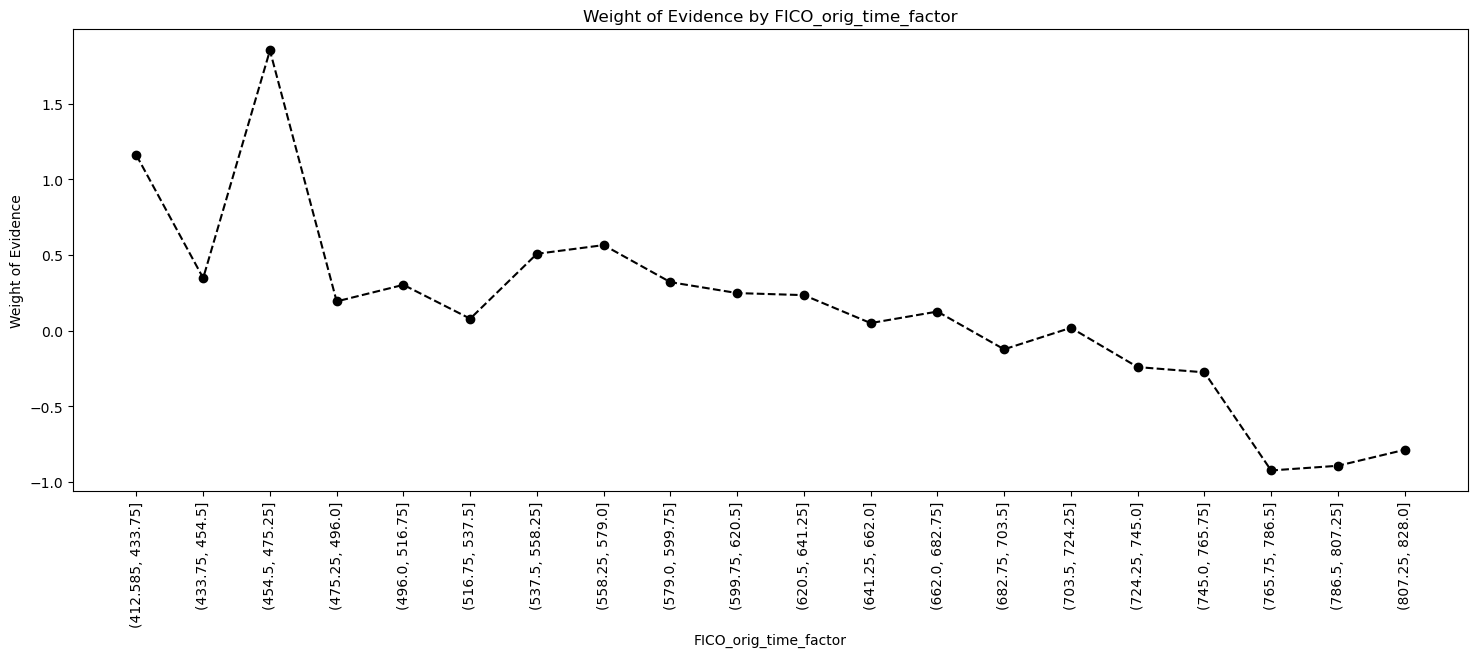

In [1235]:
plot_by_woe(FICO_orig_time_factor, 90)

In [1236]:
bins = [517.75,559.65,601.55,643.45,664.4,685.35,706.3,748.2,811.05]
df_inputs_preprocess['FICO_orig_time_factor'] = pd.cut(df_inputs_preprocess['FICO_orig_time'], bins=bins)
FICO_orig_time_factor = woe_cont(df_inputs_preprocess,'FICO_orig_time_factor', df_target_preprocess)
FICO_orig_time_factor

,FICO_orig_time_factor,n_obs,prop_bad,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_WoE,IV
0,"(517.75, 559.65]",320,0.300000,0.700000,0.061621,224.0,96.0,0.056494,0.078176,0.324821,NaN,0.09986
1,"(559.65, 601.55]",459,0.315904,0.684096,0.088388,314.0,145.0,0.079193,0.118078,0.399460,0.074639,0.09986
2,"(601.55, 643.45]",817,0.283966,0.716034,0.157327,585.0,232.0,0.147541,0.188925,0.247245,0.152215,0.09986
3,"(643.45, 664.4]",548,0.244526,0.755474,0.105527,414.0,134.0,0.104414,0.109121,0.044093,0.203152,0.09986
4,"(664.4, 685.35]",552,0.260870,0.739130,0.106297,408.0,144.0,0.102900,0.117264,0.130665,0.086572,0.09986
5,"(685.35, 706.3]",627,0.215311,0.784689,0.120739,492.0,135.0,0.124086,0.109935,-0.121085,0.251750,0.09986
6,"(706.3, 748.2]",954,0.225367,0.774633,0.183709,739.0,215.0,0.186381,0.175081,-0.062541,0.058544,0.09986
7,"(748.2, 811.05]",916,0.138646,0.861354,0.176391,789.0,127.0,0.198991,0.103420,-0.654460,0.591919,0.09986


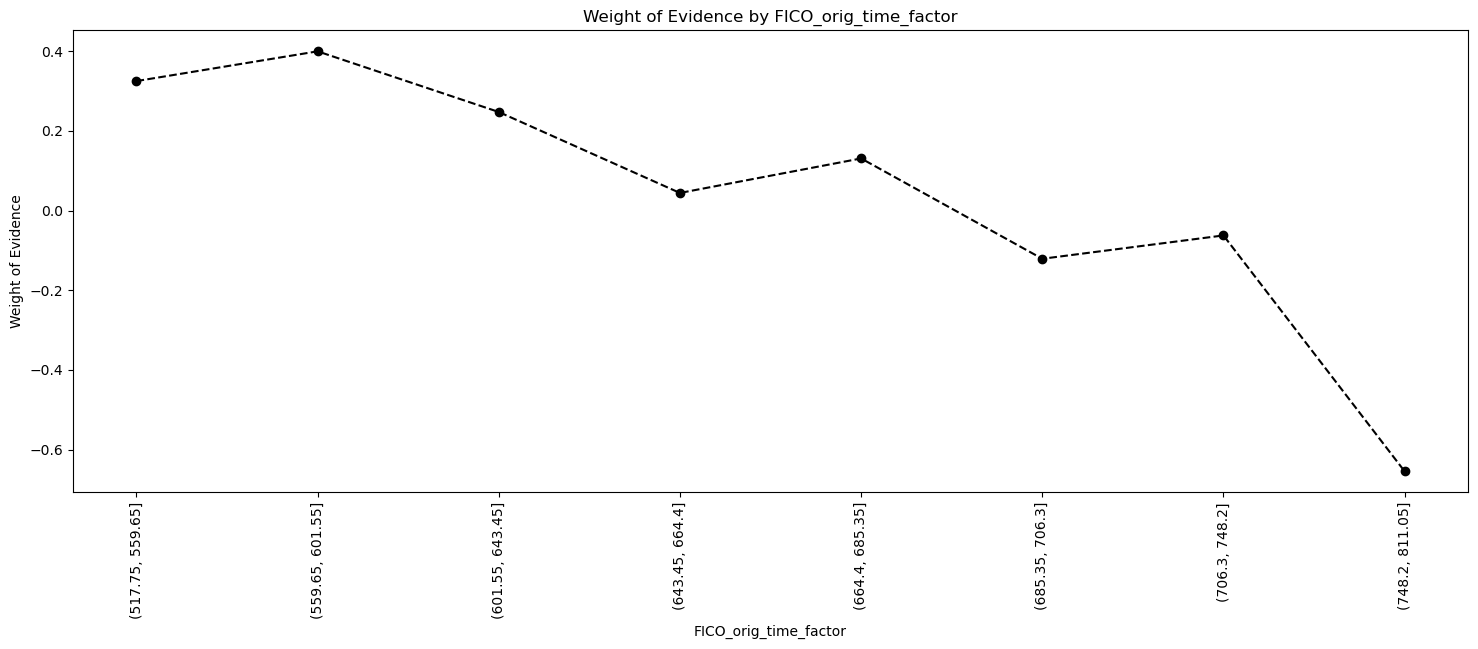

In [1237]:
plot_by_woe(FICO_orig_time_factor, 90)

In [1238]:
iv_status(FICO_orig_time_factor['IV'][0])

'weak predictor'

**Checks**

1. Similar bins group : difference of WoE should be greater than 0.2 -- Pass
2. IV value should not drop: Select no. of bins in such a way that IV should not drop -- Pass
3. Monotonicity: Pass
4. Proportion should be sufficient: Pass
5. Low no. of bins: Pass
6. No error: None of the bins should have 0 good/bad : Pass

In [1239]:
df_inputs_preprocess['FICO_orig_time'] = np.where(
    df_inputs_preprocess['FICO_orig_time'] < 559.65, 0.324821,
    np.where(
        (df_inputs_preprocess['FICO_orig_time'] >= 559.65) & (df_inputs_preprocess['FICO_orig_time'] < 601.55), 0.399460,
        np.where(
            (df_inputs_preprocess['FICO_orig_time'] >= 601.55) & (df_inputs_preprocess['FICO_orig_time'] < 643.45), 0.247245,
            np.where(
                (df_inputs_preprocess['FICO_orig_time'] >= 643.45) & (df_inputs_preprocess['FICO_orig_time'] < 664.4), 0.044093,
                np.where(
                    (df_inputs_preprocess['FICO_orig_time'] >= 664.4) & (df_inputs_preprocess['FICO_orig_time'] < 685.35), 0.130665,
                    np.where(
                        (df_inputs_preprocess['FICO_orig_time'] >= 685.35) & (df_inputs_preprocess['FICO_orig_time'] < 706.3), -0.121085,
                        np.where(
                            (df_inputs_preprocess['FICO_orig_time'] >= 706.3) & (df_inputs_preprocess['FICO_orig_time'] < 748.2), -0.062541,
                            np.where(
                                (df_inputs_preprocess['FICO_orig_time'] >= 748.2), -0.654460,
                                df_inputs_preprocess['FICO_orig_time']
                            )
                        )
                    )
                )
            )
        )
    )
)


#### WoE, IV for LTV_orig_time

In [1240]:
df_inputs_preprocess['LTV_orig_time_factor'] = pd.cut(df_inputs_preprocess['LTV_orig_time'], bins=20)
LTV_orig_time_factor = woe_cont(df_inputs_preprocess,'LTV_orig_time_factor', df_target_preprocess)
LTV_orig_time_factor

,LTV_orig_time_factor,n_obs,prop_bad,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_WoE,IV
0,"(50.025, 53.845]",111,0.126126,0.873874,0.020651,97.0,14.0,0.023711,0.010903,-0.776844,NaN,inf
1,"(53.845, 57.59]",101,0.207921,0.792079,0.018791,80.0,21.0,0.019555,0.016355,-0.178695,0.598149,inf
2,"(57.59, 61.335]",160,0.150000,0.850000,0.029767,136.0,24.0,0.033244,0.018692,-0.575792,0.397097,inf
3,"(61.335, 65.08]",258,0.170543,0.829457,0.048000,214.0,44.0,0.052310,0.034268,-0.422977,0.152815,inf
4,"(65.08, 68.825]",186,0.139785,0.860215,0.034605,160.0,26.0,0.039110,0.020249,-0.658268,0.235291,inf
5,"(68.825, 72.57]",368,0.222826,0.777174,0.068465,286.0,82.0,0.069910,0.063863,-0.090463,0.567805,inf
6,"(72.57, 76.315]",466,0.231760,0.768240,0.086698,358.0,108.0,0.087509,0.084112,-0.039593,0.050871,inf
7,"(76.315, 80.06]",2293,0.266027,0.733973,0.426605,1683.0,610.0,0.411391,0.475078,0.143935,0.183528,inf
8,"(80.06, 83.805]",80,0.212500,0.787500,0.014884,63.0,17.0,0.015400,0.013240,-0.151112,0.295047,inf
9,"(83.805, 87.55]",281,0.266904,0.733096,0.052279,206.0,75.0,0.050354,0.058411,0.148421,0.299533,inf


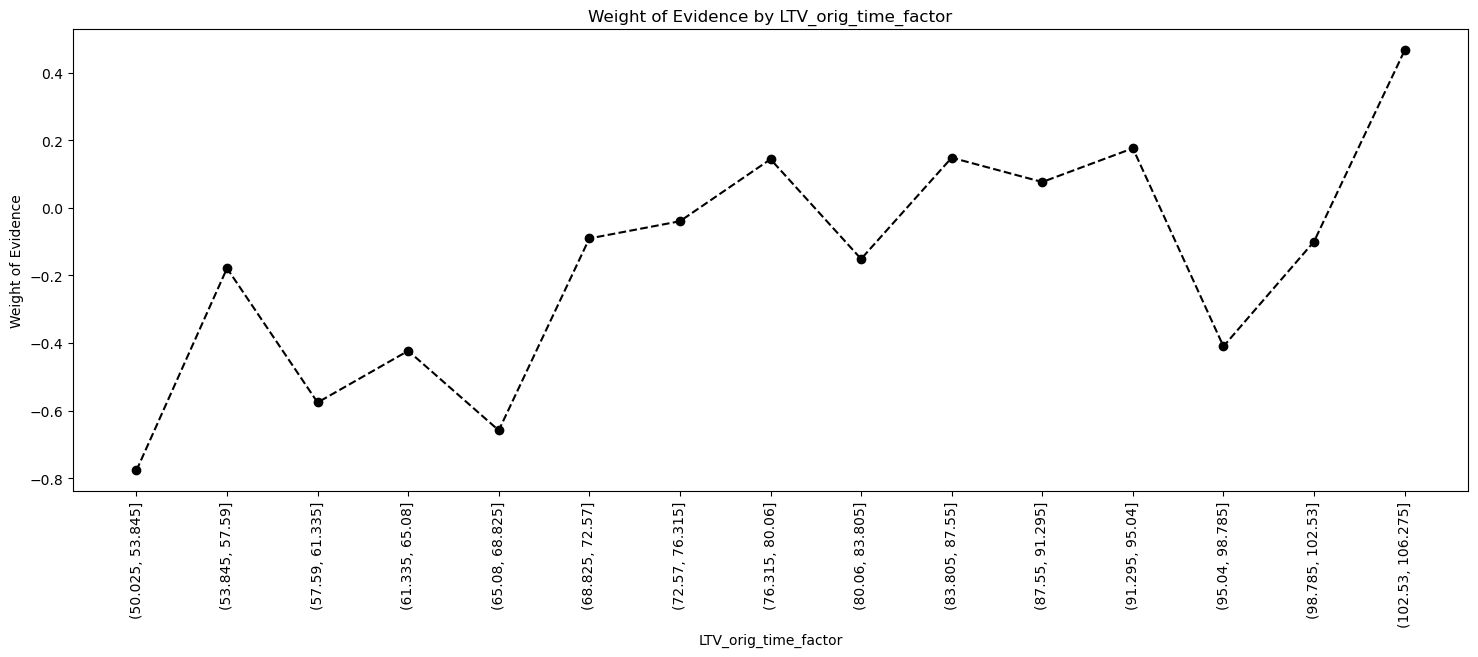

In [1241]:
plot_by_woe(LTV_orig_time_factor, 90)

In [1242]:
bins = [64.395,78.69,88.22,92.985,140.635]
df_inputs_preprocess['LTV_orig_time_factor'] = pd.cut(df_inputs_preprocess['LTV_orig_time'], bins=bins)
LTV_orig_time_factor = woe_cont(df_inputs_preprocess,'LTV_orig_time_factor', df_target_preprocess)
LTV_orig_time_factor

,LTV_orig_time_factor,n_obs,prop_bad,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_WoE,IV
0,"(64.395, 78.69]",1346,0.215453,0.784547,0.276613,1056.0,290.0,0.288840,0.239669,-0.186613,NaN,0.01429
1,"(78.69, 88.22]",2473,0.267287,0.732713,0.508220,1812.0,661.0,0.495624,0.546281,0.097317,0.283930,0.01429
2,"(88.22, 92.985]",482,0.253112,0.746888,0.099055,360.0,122.0,0.098468,0.100826,0.023666,0.073650,0.01429
3,"(92.985, 140.635]",565,0.242478,0.757522,0.116112,428.0,137.0,0.117068,0.113223,-0.033393,0.057059,0.01429


In [1243]:
iv_status(LTV_orig_time_factor['IV'][0])

'useless'

#### WoE, IV for MOB

In [1244]:
df_inputs_preprocess['MOB_factor'] = pd.cut(df_inputs_preprocess['MOB'], bins=20)
MOB_factor = woe_cont(df_inputs_preprocess,'MOB_factor', df_target_preprocess)
MOB_factor

,MOB_factor,n_obs,prop_bad,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_WoE,IV
0,"(11.931, 15.45]",2411,0.305268,0.694732,0.448558,1675.0,736.0,0.409435,0.573209,0.336471,NaN,inf
1,"(15.45, 18.9]",1147,0.230166,0.769834,0.213395,883.0,264.0,0.215840,0.205607,-0.048567,0.385038,inf
2,"(18.9, 22.35]",881,0.175936,0.824064,0.163907,726.0,155.0,0.177463,0.120717,-0.385316,0.336749,inf
3,"(22.35, 25.8]",368,0.138587,0.861413,0.068465,317.0,51.0,0.077487,0.039720,-0.668267,0.282951,inf
4,"(25.8, 29.25]",226,0.132743,0.867257,0.042047,196.0,30.0,0.047910,0.023364,-0.718108,0.049841,inf
5,"(29.25, 32.7]",93,0.161290,0.838710,0.017302,78.0,15.0,0.019066,0.011682,-0.489849,0.228259,inf
6,"(32.7, 36.15]",67,0.179104,0.820896,0.012465,55.0,12.0,0.013444,0.009346,-0.363617,0.126232,inf
7,"(36.15, 39.6]",45,0.088889,0.911111,0.008372,41.0,4.0,0.010022,0.003115,-1.168468,0.804851,inf
8,"(39.6, 43.05]",44,0.159091,0.840909,0.008186,37.0,7.0,0.009044,0.005452,-0.506199,0.662270,inf
9,"(43.05, 46.5]",30,0.166667,0.833333,0.005581,25.0,5.0,0.006111,0.003894,-0.450629,0.055570,inf


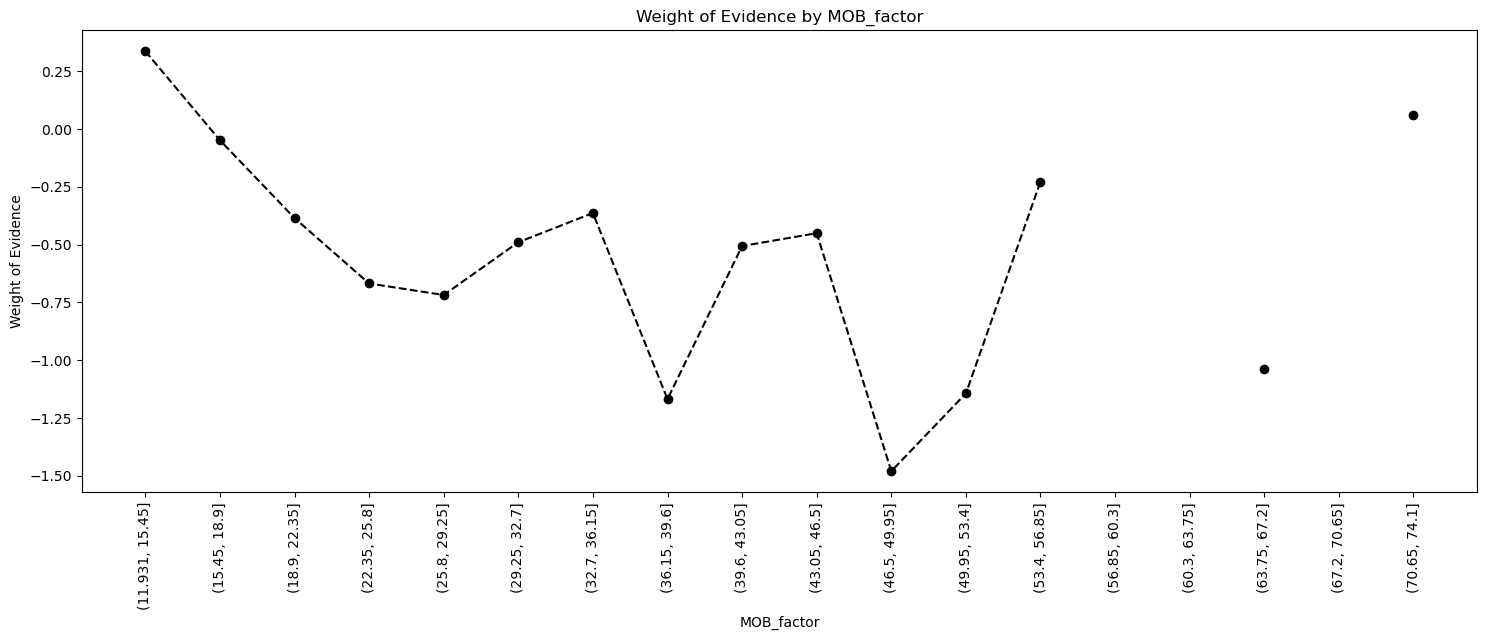

In [1245]:
plot_by_woe(MOB_factor, 90)

In [1246]:
bins = [11.931,15.45,18.9,22.35,77.55]
df_inputs_preprocess['MOB_factor'] = pd.cut(df_inputs_preprocess['MOB'], bins=bins)
MOB_factor = woe_cont(df_inputs_preprocess,'MOB_factor', df_target_preprocess)
MOB_factor

,MOB_factor,n_obs,prop_bad,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_WoE,IV
0,"(11.931, 15.45]",2411,0.305268,0.694732,0.448809,1675.0,736.0,0.409736,0.573209,0.335737,NaN,0.141976
1,"(15.45, 18.9]",1147,0.230166,0.769834,0.213515,883.0,264.0,0.215998,0.205607,-0.049300,0.385038,0.141976
2,"(18.9, 22.35]",881,0.175936,0.824064,0.163999,726.0,155.0,0.177593,0.120717,-0.386049,0.336749,0.141976
3,"(22.35, 77.55]",933,0.138264,0.861736,0.173678,804.0,129.0,0.196673,0.100467,-0.671711,0.285662,0.141976


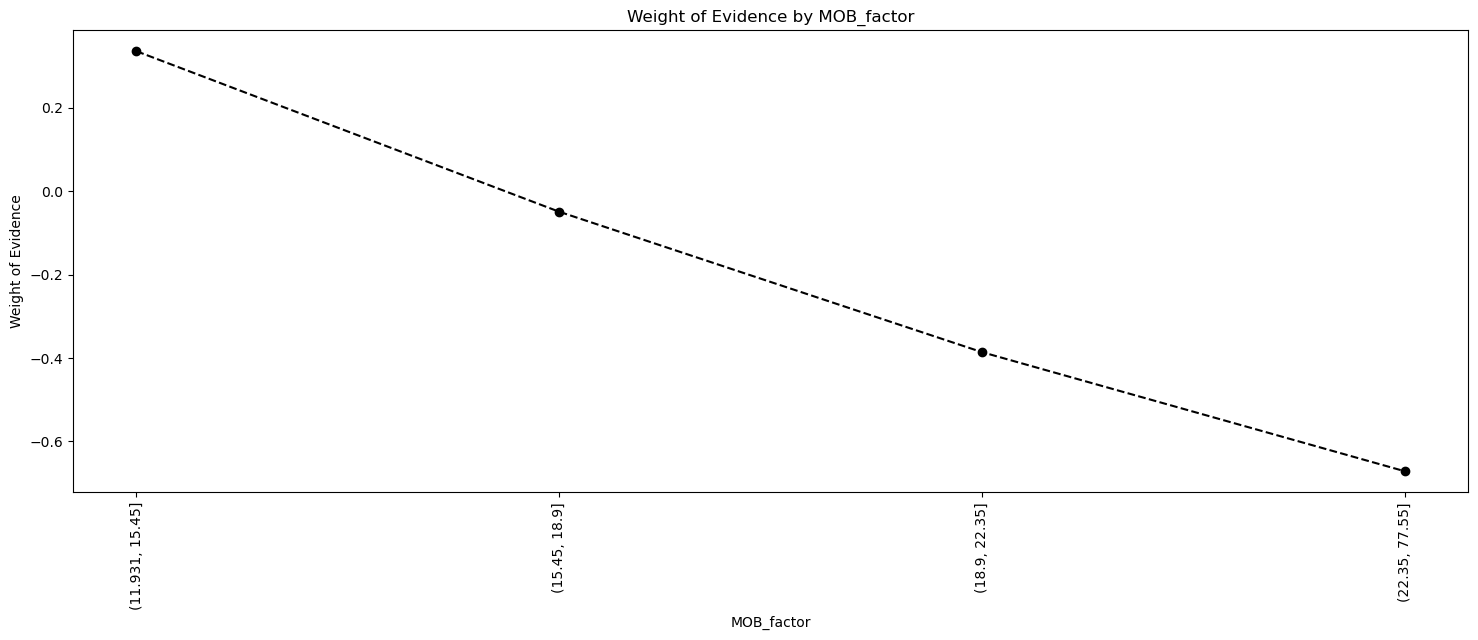

In [1247]:
plot_by_woe(MOB_factor, 90)

In [1248]:
iv_status(MOB_factor['IV'][0])

'medium predictor'

**Checks**

1. Similar bins group : difference of WoE should be greater than 0.2 -- Pass
2. IV value should not drop: Select no. of bins in such a way that IV should not drop -- NA
3. Monotonicity: Exception
4. Proportion should be sufficient: Pass
5. Low no. of bins: Pass
6. No error: None of the bins should have 0 good/bad : Pass

In [1249]:
conditions = [
    (df_inputs_preprocess['MOB'] < 15.45),
    (df_inputs_preprocess['MOB'] >= 15.45) & (df_inputs_preprocess['MOB'] < 18.9),
    (df_inputs_preprocess['MOB'] >= 18.9) & (df_inputs_preprocess['MOB'] < 22.35),
    (df_inputs_preprocess['MOB'] >= 22.35)
]

values = [0.287173, -0.013995, -0.277105, -0.648568]

df_inputs_preprocess['MOB'] = np.select(conditions, values)

#### WoE, IV for cep_time

In [1250]:
df_inputs_preprocess['cep_time_factor'] = pd.cut(df_inputs_preprocess['cep_time'], bins=50)
cep_time_factor = woe_cont(df_inputs_preprocess,'cep_time_factor', df_target_preprocess)
cep_time_factor

,cep_time_factor,n_obs,prop_bad,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_WoE,IV
0,"(-0.431, -0.404]",4,0.000000,1.000000,0.000744,4.0,0.0,0.000978,0.000000,-inf,NaN,inf
1,"(-0.404, -0.379]",0,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,inf
2,"(-0.379, -0.353]",0,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,inf
3,"(-0.353, -0.328]",1,0.000000,1.000000,0.000186,1.0,0.0,0.000244,0.000000,-inf,NaN,inf
4,"(-0.328, -0.303]",0,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,inf
5,"(-0.303, -0.277]",1,0.000000,1.000000,0.000186,1.0,0.0,0.000244,0.000000,-inf,NaN,inf
6,"(-0.277, -0.252]",3,0.333333,0.666667,0.000558,2.0,1.0,0.000489,0.000779,0.465662,inf,inf
7,"(-0.252, -0.227]",2,0.500000,0.500000,0.000372,1.0,1.0,0.000244,0.000779,1.158809,0.693147,inf
8,"(-0.227, -0.201]",5,0.200000,0.800000,0.000930,4.0,1.0,0.000978,0.000779,-0.227485,1.386294,inf
9,"(-0.201, -0.176]",8,0.250000,0.750000,0.001488,6.0,2.0,0.001467,0.001558,0.060197,0.287682,inf


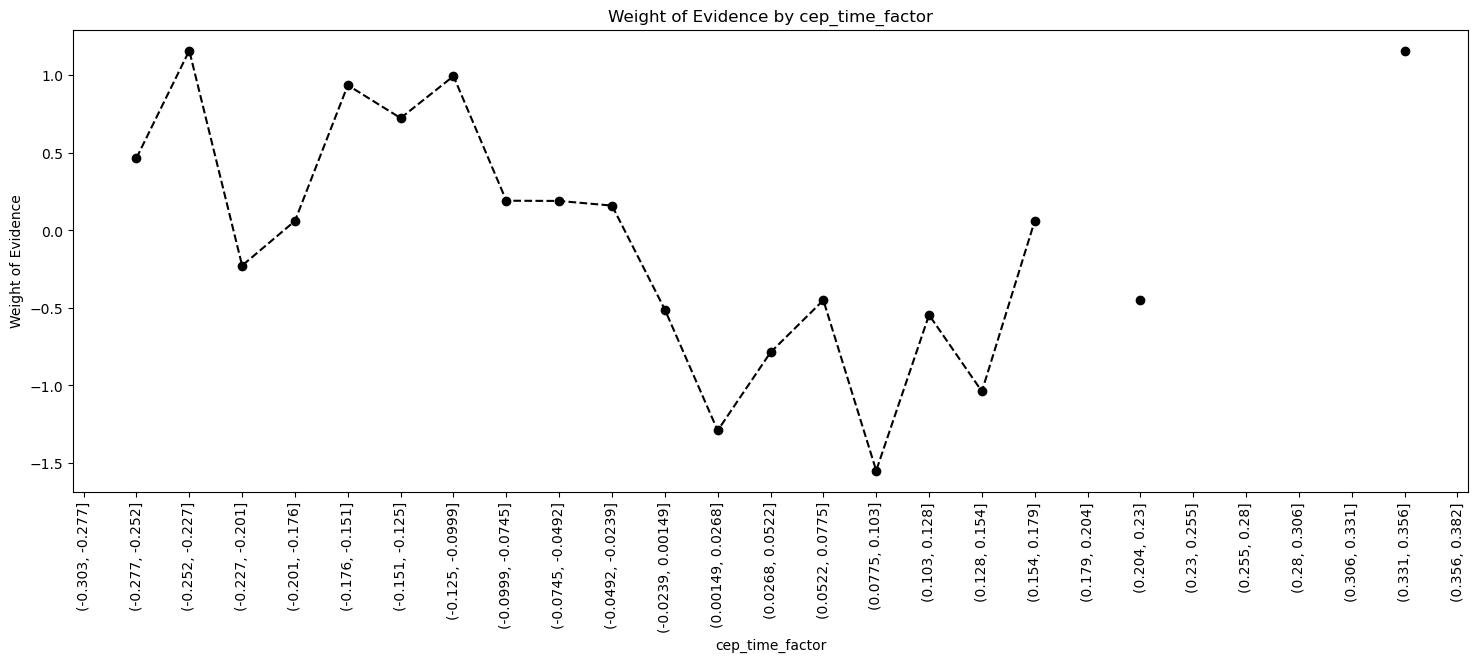

In [1251]:
plot_by_woe(cep_time_factor,90)

In [1252]:
bins = [-0.516,-0.10,-0.08,-0.03,0.82]
df_inputs_preprocess['cep_time_factor'] = pd.cut(df_inputs_preprocess['cep_time'], bins=bins)
cep_time_factor = woe_cont(df_inputs_preprocess,'cep_time_factor', df_target_preprocess)
cep_time_factor

,cep_time_factor,n_obs,prop_bad,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_WoE,IV
0,"(-0.516, -0.1]",252,0.420635,0.579365,0.046892,146.0,106.0,0.035697,0.082555,0.838397,NaN,0.147807
1,"(-0.1, -0.08]",248,0.266129,0.733871,0.046148,182.0,66.0,0.044499,0.051402,0.144213,0.694184,0.147807
2,"(-0.08, -0.03]",2558,0.284597,0.715403,0.475996,1830.0,728.0,0.447433,0.566978,0.236795,0.092582,0.147807
3,"(-0.03, 0.82]",2316,0.165803,0.834197,0.430964,1932.0,384.0,0.472372,0.299065,-0.457104,0.693898,0.147807


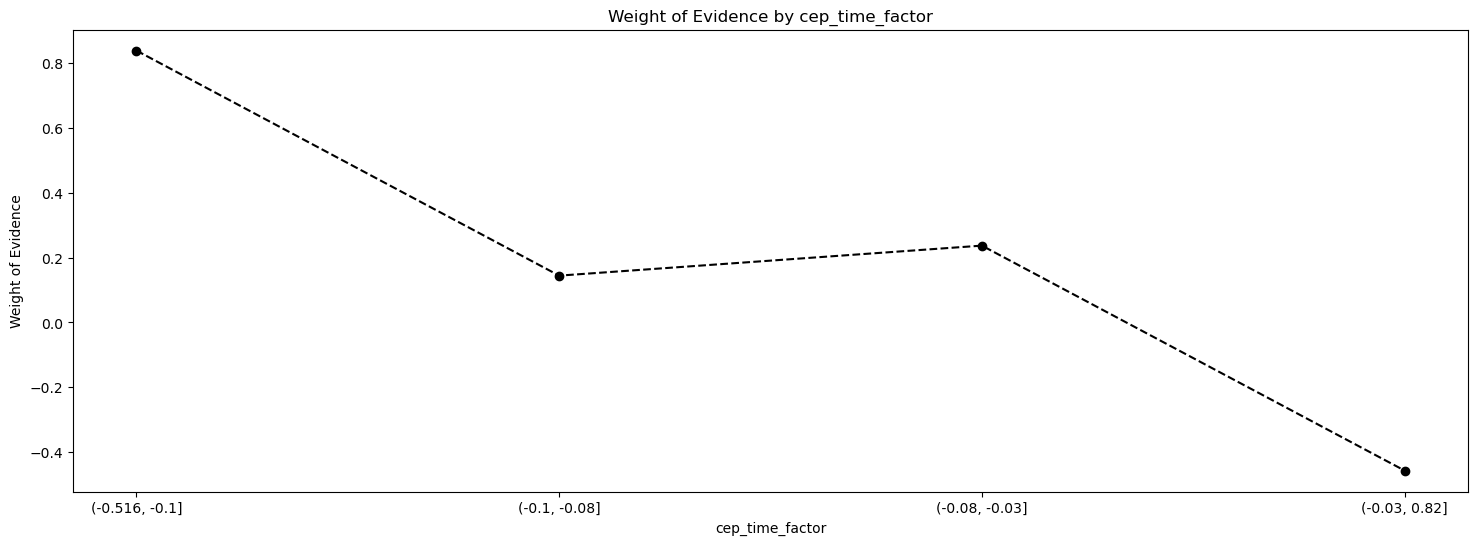

In [1253]:
plot_by_woe(cep_time_factor)

In [1254]:
iv_status(cep_time_factor['IV'][0])

'medium predictor'

**Checks**

1. Similar bins group : difference of WoE should be greater than 0.2 -- Partial Pass
2. IV value should not drop: Select no. of bins in such a way that IV should not drop -- NA
3. Monotonicity: Pass
4. Proportion should be sufficient: Partial Pass
5. Low no. of bins: Pass
6. No error: None of the bins should have 0 good/bad : Pass

In [1255]:
conditions = [
    (df_inputs_preprocess['cep_time'] < -0.10),
    (df_inputs_preprocess['cep_time'] >= -0.10) & (df_inputs_preprocess['cep_time'] < -0.08),
    (df_inputs_preprocess['cep_time'] >= -0.08) & (df_inputs_preprocess['cep_time'] < -0.03),
    (df_inputs_preprocess['cep_time'] >= 0.82)
]

values = [0.842729, 0.292882, 0.207130, -0.471250]

df_inputs_preprocess['cep_time'] = np.select(conditions, values)

#### WoE, IV for uer_time

In [1256]:
df_inputs_preprocess['uer_time'].unique()

array([9. , 5. , 9.9, 4.7, 4.5, 6. , 5.2, 5.6, 5.9, 4.4])

In [1257]:
uer_time_factor = woe_discrete(df_inputs_preprocess, 'uer_time', df_target_preprocess)
uer_time_factor

,uer_time,n_obs,prop_bad,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_WoE,IV
0,4.5,508,0.159449,0.840551,0.094512,427.0,81.0,0.104375,0.063084,-0.503526,NaN,0.043088
1,4.7,279,0.182796,0.817204,0.051907,228.0,51.0,0.055732,0.039720,-0.338711,0.164815,0.043088
2,5.2,99,0.202020,0.797980,0.018419,79.0,20.0,0.019311,0.015576,-0.214906,0.123804,0.043088
3,5.0,887,0.213078,0.786922,0.165023,698.0,189.0,0.170618,0.147196,-0.147663,0.067243,0.043088
4,6.0,8,0.250000,0.750000,0.001488,6.0,2.0,0.001467,0.001558,0.060197,0.207860,0.043088
5,9.9,2040,0.254412,0.745588,0.379535,1521.0,519.0,0.371792,0.404206,0.083590,0.023393,0.043088
6,9.0,1538,0.270481,0.729519,0.286140,1122.0,416.0,0.274261,0.323988,0.166626,0.083037,0.043088
7,5.9,6,0.333333,0.666667,0.001116,4.0,2.0,0.000978,0.001558,0.465662,0.299036,0.043088
8,5.6,8,0.375000,0.625000,0.001488,5.0,3.0,0.001222,0.002336,0.647984,0.182322,0.043088
9,4.4,2,0.500000,0.500000,0.000372,1.0,1.0,0.000244,0.000779,1.158809,0.510826,0.043088


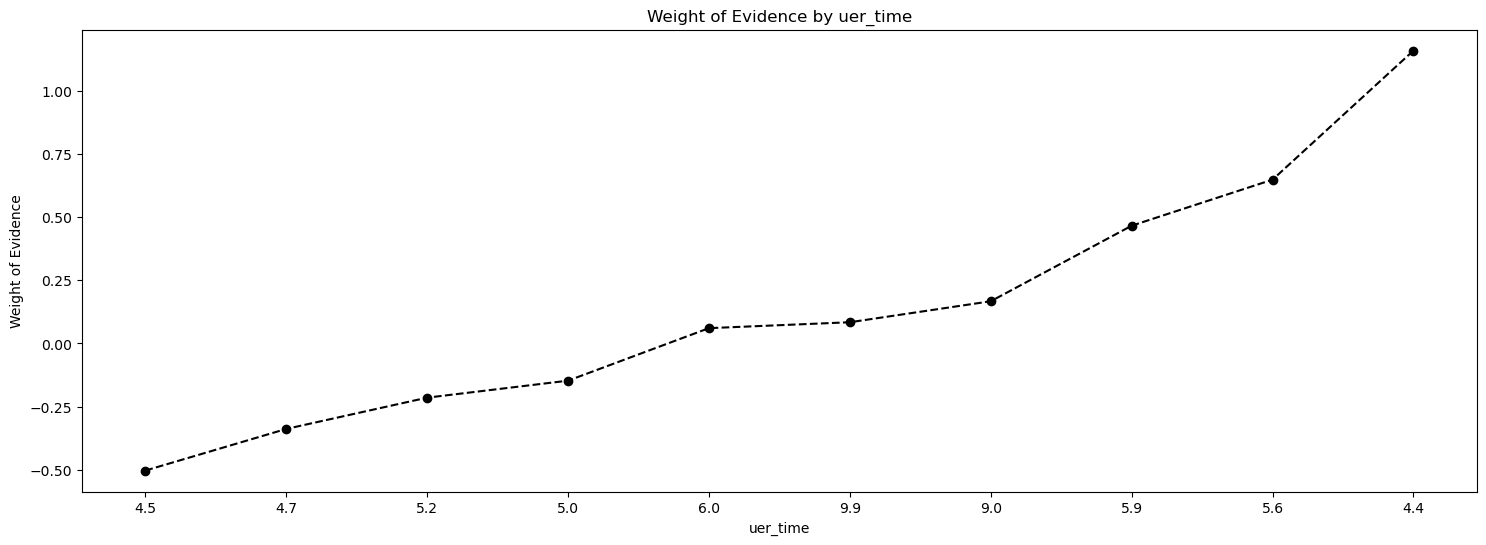

In [1258]:
plot_by_woe(uer_time_factor)

In [1259]:
conditions = [
    (df_inputs_preprocess['uer_time'] == 4.4) | (df_inputs_preprocess['uer_time'] == 4.5) | 
    (df_inputs_preprocess['uer_time'] == 4.6) | (df_inputs_preprocess['uer_time'] == 4.7),
    
    (df_inputs_preprocess['uer_time'] == 5.9) | (df_inputs_preprocess['uer_time'] == 5),
    
    (df_inputs_preprocess['uer_time'] == 5.2) | (df_inputs_preprocess['uer_time'] == 9) | 
    (df_inputs_preprocess['uer_time'] == 9.9) | (df_inputs_preprocess['uer_time'] == 5.6)
]


values = [4.7,5,5.6]

df_inputs_preprocess['uer_time'] = np.select(conditions, values, default=df_inputs_preprocess['uer_time'])

In [1260]:
uer_time_factor = woe_discrete(df_inputs_preprocess, 'uer_time', df_target_preprocess)
uer_time_factor

,uer_time,n_obs,prop_bad,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_WoE,IV
0,4.7,789,0.168568,0.831432,0.146791,656.0,133.0,0.160352,0.103583,-0.437002,NaN,0.037039
1,5.0,893,0.213886,0.786114,0.166140,702.0,191.0,0.171596,0.148754,-0.142851,0.294152,0.037039
2,6.0,8,0.250000,0.750000,0.001488,6.0,2.0,0.001467,0.001558,0.060197,0.203048,0.037039
3,5.6,3685,0.259973,0.740027,0.685581,2727.0,958.0,0.666585,0.746106,0.112700,0.052503,0.037039


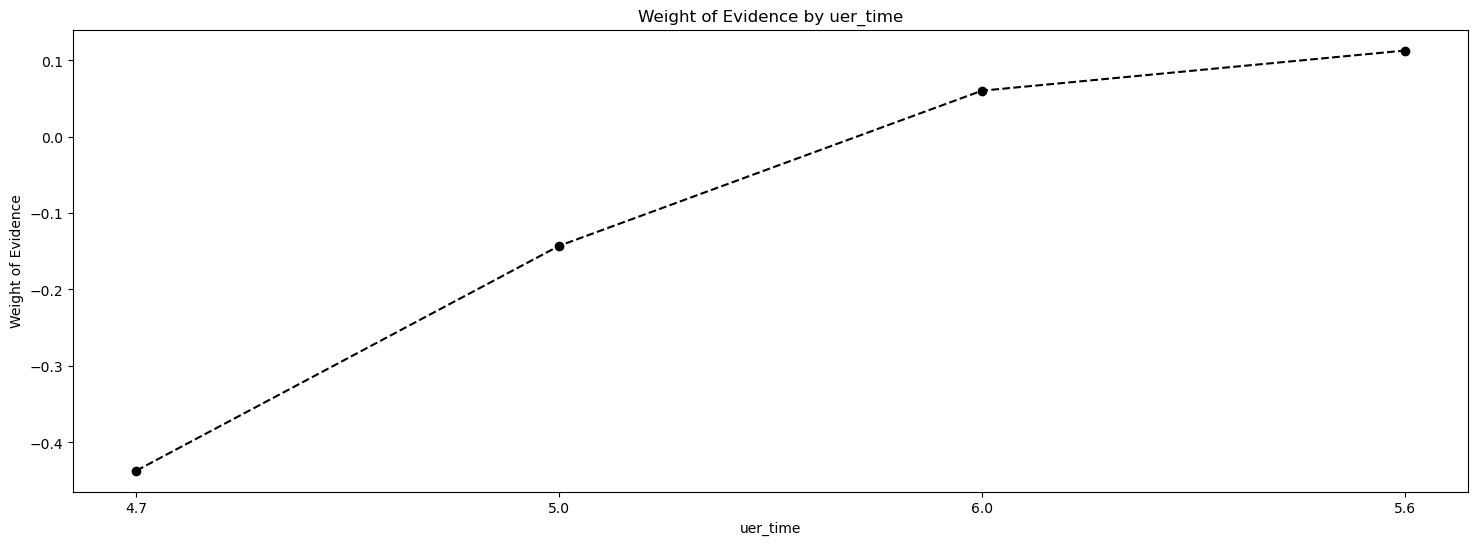

In [1261]:
plot_by_woe(uer_time_factor)

In [1262]:
conditions = [
    (df_inputs_preprocess['uer_time'] == 4.7),
    (df_inputs_preprocess['uer_time'] == 6.0),
    (df_inputs_preprocess['uer_time'] == 5.0),
    (df_inputs_preprocess['uer_time'] == 5.6)
]

values = [-0.550729,-0.549956, -0.143219, 0.128576]

df_inputs_preprocess['uer_time'] = np.select(conditions, values)

In [1263]:
iv_status(uer_time_factor['IV'][0])

'weak predictor'

**Checks**

1. Similar bins group : difference of WoE should be greater than 0.2 -- Pass
2. IV value should not drop: Select no. of bins in such a way that IV should not drop -- NA
3. Monotonicity: Pass
4. Proportion should be sufficient: Pass
5. Low no. of bins: Pass
6. No error: None of the bins should have 0 good/bad : Pass

#### WoE, IV for hpi_time

In [1264]:
df_inputs_preprocess['hpi_time'].unique()

array([153.35, 180.52, 161.06, 226.29, 217.37, 149.7 , 208.86, 179.45,
       132.76, 120.03])

In [1265]:
hpi_time_factor = woe_discrete(df_inputs_preprocess, 'hpi_time', df_target_preprocess)
hpi_time_factor

,hpi_time,n_obs,prop_bad,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_WoE,IV
0,217.37,508,0.159449,0.840551,0.094512,427.0,81.0,0.104375,0.063084,-0.503526,NaN,0.043088
1,226.29,279,0.182796,0.817204,0.051907,228.0,51.0,0.055732,0.039720,-0.338711,0.164815,0.043088
2,208.86,99,0.202020,0.797980,0.018419,79.0,20.0,0.019311,0.015576,-0.214906,0.123804,0.043088
3,180.52,887,0.213078,0.786922,0.165023,698.0,189.0,0.170618,0.147196,-0.147663,0.067243,0.043088
4,149.70,8,0.250000,0.750000,0.001488,6.0,2.0,0.001467,0.001558,0.060197,0.207860,0.043088
5,161.06,2040,0.254412,0.745588,0.379535,1521.0,519.0,0.371792,0.404206,0.083590,0.023393,0.043088
6,153.35,1538,0.270481,0.729519,0.286140,1122.0,416.0,0.274261,0.323988,0.166626,0.083037,0.043088
7,132.76,6,0.333333,0.666667,0.001116,4.0,2.0,0.000978,0.001558,0.465662,0.299036,0.043088
8,179.45,8,0.375000,0.625000,0.001488,5.0,3.0,0.001222,0.002336,0.647984,0.182322,0.043088
9,120.03,2,0.500000,0.500000,0.000372,1.0,1.0,0.000244,0.000779,1.158809,0.510826,0.043088


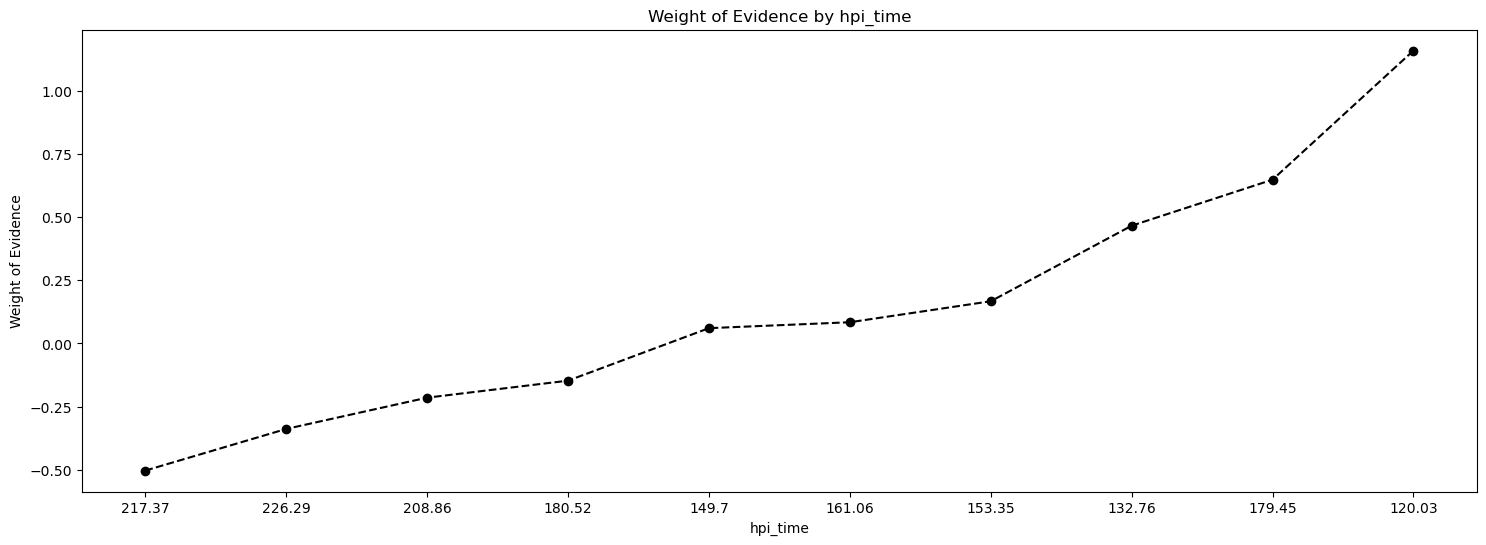

In [1266]:
plot_by_woe(hpi_time_factor)

In [1267]:
conditions = [
    (df_inputs_preprocess['hpi_time'] == 120.03) | (df_inputs_preprocess['hpi_time'] == 217.37) | 
    (df_inputs_preprocess['hpi_time'] == 149.7),
    
    (df_inputs_preprocess['hpi_time'] == 226.29) | (df_inputs_preprocess['hpi_time'] == 132.76),

    (df_inputs_preprocess['hpi_time'] == 180.52),
    
    (df_inputs_preprocess['hpi_time'] == 208.86) | (df_inputs_preprocess['hpi_time'] == 153.35) |
    (df_inputs_preprocess['hpi_time'] == 161.06) | (df_inputs_preprocess['hpi_time'] == 179.45)
]


values = [149.7,132.76,180.52,179.45]

df_inputs_preprocess['hpi_time'] = np.select(conditions, values, default=df_inputs_preprocess['hpi_time'])

In [1268]:
hpi_time_factor = woe_discrete(df_inputs_preprocess, 'hpi_time', df_target_preprocess)
hpi_time_factor

,hpi_time,n_obs,prop_bad,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_WoE,IV
0,149.70,518,0.162162,0.837838,0.096372,434.0,84.0,0.106087,0.065421,-0.483419,NaN,0.036981
1,132.76,285,0.185965,0.814035,0.053023,232.0,53.0,0.056710,0.041277,-0.317636,0.165782,0.036981
2,180.52,887,0.213078,0.786922,0.165023,698.0,189.0,0.170618,0.147196,-0.147663,0.169973,0.036981
3,179.45,3685,0.259973,0.740027,0.685581,2727.0,958.0,0.666585,0.746106,0.112700,0.260362,0.036981


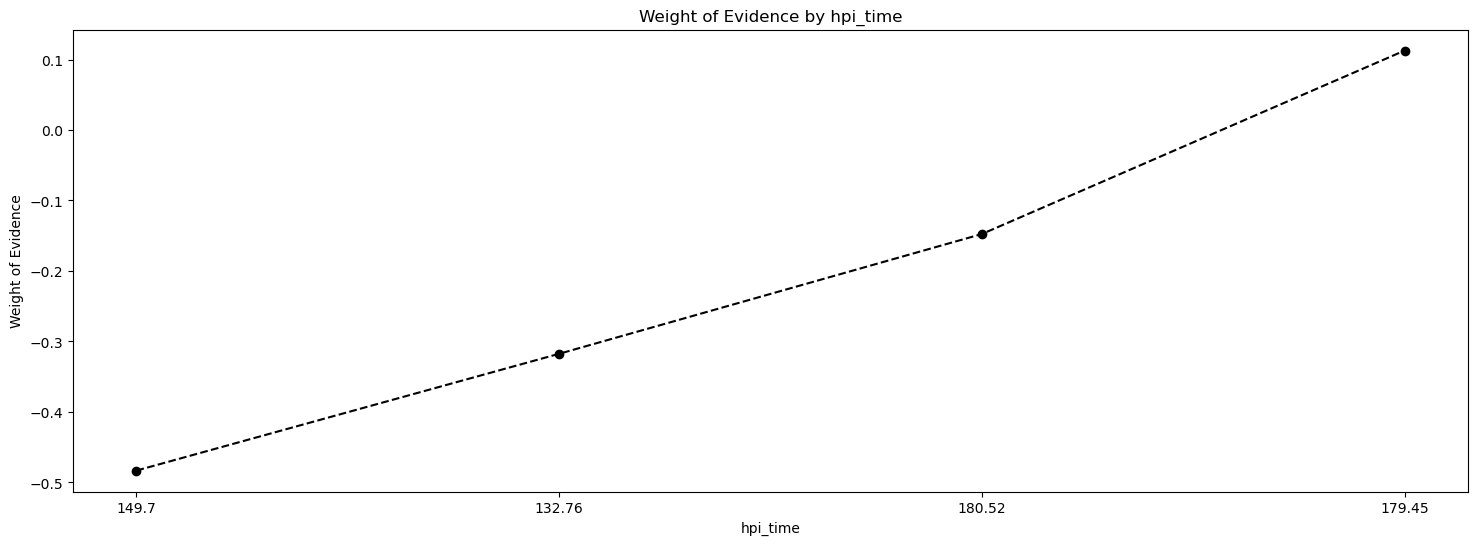

In [1269]:
plot_by_woe(hpi_time_factor)

In [1270]:
conditions = [
    (df_inputs_preprocess['hpi_time'] == 149.70), (df_inputs_preprocess['hpi_time'] == 132.76),
    (df_inputs_preprocess['hpi_time'] == 180.52), (df_inputs_preprocess['hpi_time'] == 179.45)
]


values = [-0.581928,-0.487435,-0.141930,0.128576]

df_inputs_preprocess['hpi_time'] = np.select(conditions, values, default=df_inputs_preprocess['hpi_time'])

In [1271]:
iv_status(hpi_time_factor['IV'][0])

'weak predictor'

**Checks**

1. Similar bins group : difference of WoE should be greater than 0.2 -- Partial Pass
2. IV value should not drop: Select no. of bins in such a way that IV should not drop -- NA
3. Monotonicity: Pass
4. Proportion should be sufficient: Pass
5. Low no. of bins: Pass
6. No error: None of the bins should have 0 good/bad : Pass

**Interpretation**

1.	Interest_Rate_orig_time :	Non intiutive graph
2.	FICO_orig_time :	medium predictor
3.	LTV_orig_time :	useless
4.	MOB :	medium predictor
5.	cep_time :	medium predictor
6.	uer_time :	weak predictor
7.	hpi_time :	weak predictor
8.	Vintage1 : N/A
9.	Vintage2 : N/A
10.	Vintage3 : N/A

In [1272]:
df_inputs_preprocess.columns

Index(['hpi_time', 'uer_time', 'FICO_orig_time', 'LTV_orig_time', 'MOB',
       'cep_time', 'Vintage1', 'Vintage2', 'Vintage3',
       'Interest_Rate_orig_time_factor', 'FICO_orig_time_factor',
       'LTV_orig_time_factor', 'MOB_factor', 'cep_time_factor'],
      dtype='object')

In [1273]:
cols_to_remove = ['LTV_orig_time', 'Interest_Rate_orig_time_factor', 'FICO_orig_time_factor',
       'LTV_orig_time_factor', 'MOB_factor', 'cep_time_factor']
df_inputs_preprocess.drop(columns=cols_to_remove, inplace=True)

In [1274]:
df_inputs_preprocess.columns

Index(['hpi_time', 'uer_time', 'FICO_orig_time', 'MOB', 'cep_time', 'Vintage1',
       'Vintage2', 'Vintage3'],
      dtype='object')

In [1275]:
#X_train = df_inputs_preprocess
X_test = df_inputs_preprocess

In [1276]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21497, 8), (5375, 8), (21497,), (5375,))

In [1277]:
X_train.to_csv('X_train_loan_data.csv')
X_test.to_csv('X_test_loan_data.csv')
y_train.to_csv('y_train_loan_data.csv')
y_test.to_csv('y_test_loan_data.csv')

In [1278]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21497, 8), (5375, 8), (21497,), (5375,))

In [1279]:
X_train.columns == X_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True])

In [1280]:
X_train.nunique()

hpi_time          4
uer_time          4
FICO_orig_time    8
MOB               4
cep_time          4
Vintage1          2
Vintage2          2
Vintage3          2
dtype: int64

**------------------------------------------------------------------------------Data is ready for modelling------------------------------------------------------------------------------**